In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# torch.manual_seed(42)

In [2]:
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'device: {device}')

device: cpu


In [3]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,t):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,t], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            m = self.linears[i](a)
            a = self.activation(m)


            
        b = self.linears[-1](a) 
         
        return b
    
    def forward_direct(self, x,t):
        
        m = torch.cat([x,t], dim = 1)    #(N,2)    

        W1 = self.linears[0].weight    # (20,2)

        H_x = W1[:, 0].unsqueeze(0)      # (1,20)
        F_x = torch.zeros_like(H_x)

        H_t = W1[:, 1].unsqueeze(0)      # (1,20)
        F_t = torch.zeros_like(H_t)


        

        for i in range(len(self.layers)-2):
            L = self.linears[i](m)            # (N,20)
            m = self.activation(L)            # (N,20)
            m_1 = 1.0-torch.square(m)         # (N,20)

            G_x = m_1*H_x     #\sigma'(L)*H   # (N,20)
            G_t = m_1*H_t
            

            C_x = (-2*m + 2*torch.pow(m,3))*H_x*H_x
            C_t = (-2*m + 2*torch.pow(m,3))*H_t*H_t
          


            E_x = C_x + m_1*F_x    # (N,20)
            E_t = C_t + m_1*F_t    # (N,20)
           


            H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
            F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

            H_t = torch.matmul(G_t,self.linears[i+1].weight.t())
            F_t = torch.matmul(E_t,self.linears[i+1].weight.t())


        m = self.linears[-1](m)
         
        # return z, H_x, H_y, H_t, F_x, F_y, F_t
        return m, H_x, H_t, F_x, F_t


    # # TENSORIZED
    
    
    # def forward_direct(self, x,t):
        
    #     z = torch.cat([x,t], dim = 1)    #(N,2)      N = 90000
    #     N = z.size(0)

    #     W1 = self.linears[0].weight    # (20,2)

    #     H = W1.unsqueeze(0).expand(N,-1,-1).contiguous()     #(N,20,2)
    #     F = torch.zeros_like(H)

    #     # H_x = W1[:, 0].unsqueeze(0)      # (1,20)
    #     # F_x = torch.zeros_like(H_x)

    #     # H_t = W1[:, 1].unsqueeze(0)      # (1,20)
    #     # F_t = torch.zeros_like(H_t)
        

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)            # (N,20)
    #         z = self.activation(L)            # (N,20)
    #         z_1 = 1.0-torch.square(z)         # (N,20)
    #         z_1 = z_1.unsqueeze(-1)           # (N,20,1)

    #         G = z_1*H     #\sigma'(L)*H   # (N,20,2)

    #         # G_x = z_1*H_x     #\sigma'(L)*H   # (N,20)
    #         # G_t = z_1*H_t                     # (N,20)

    #         z_2 = (-2*z + 2*torch.pow(z,3))   #(N,20)
    #         z_2 = z_2.unsqueeze(-1)           # (N,20,1)

    #         C = z_2*H*H                       # (N,20,2)




    #         # C_x = (-2*z + 2*torch.pow(z,3))*H_x*H_x
    #         # C_t = (-2*z + 2*torch.pow(z,3))*H_t*H_t

    #         E = C + z_1*F                     # (N,20,2)     

    #         # E_x = C_x + z_1*F_x    # (N,50)
    #         # E_t = C_t + z_1*F_t    # (N,50)

    #         H = torch.matmul(G.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,2,20) * (20,1)  = (N,2,1).t() = (N,1,2)
    #         F = torch.matmul(E.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,1,2)


    #         # H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
    #         # F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

    #         # H_t = torch.matmul(G_t,self.linears[i+1].weight.t())
    #         # F_t = torch.matmul(E_t,self.linears[i+1].weight.t())

    #     z = self.linears[-1](z)

    #     H_x = H[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     H_t = H[:, 0, 1].unsqueeze(-1)   # (N,1)
    #     F_x = F[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     F_t = F[:, 0, 1].unsqueeze(-1)   # (N,1)
         
    #     return z, H_x, H_t, F_x, F_t
    


In [4]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [41]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [5]:
# Create the training data

import math

T=2*math.pi

x_train = torch.linspace(-1,1,20000).view(-1,1)
t_train = torch.linspace(0,1,20000).view(-1,1) * T


# x_train = x.requires_grad_(True)      
# t_train = t.requires_grad_(True)     

# x_train = x_train.reshape(-1,1).requires_grad_(True)     
# t_train = t_train.reshape(-1,1).requires_grad_(True)    

In [6]:
# Create boundary points

def generate_boundary_points(N = 200):
    x_l = -torch.ones(N,1) ; x_r = torch.ones(N,1); t_lr = torch.linspace(0,1,N) * T

    x_l = x_l.view(-1,1)
    x_r = x_r.view(-1,1)
    t_lr = t_lr.view(-1,1)
   

  

    # x_0 = x_0.to(device)
    # x_1 = x_1.to(device)
    # ylr = ylr.to(device)


    return x_l, x_r, t_lr

In [7]:
def boundary_condition():

    x_l, x_r, t_lr = generate_boundary_points(N = 200)

    u_left = PINN(x_l, t_lr)
    u_right = PINN(x_r, t_lr)


    res_left = u_left - (-torch.cos(t_lr))
    res_right = u_right - torch.cos(t_lr)

    return res_left, res_right

In [8]:
def generate_initial_points(N = 100):
    x_i = torch.linspace(-1, 1,N).view(-1,1)
    t_i = torch.zeros(N,1).view(-1,1)
    # t_i = torch.zeros(N,1).view(-1,1).requires_grad_(True)
    return x_i, t_i

In [9]:
def initial_condition():

  x_i, t_i = generate_initial_points(N = 100)
  
  u_ic = PINN(x_i, t_i)

  res_ic_1 = u_ic - x_i



  m, H_x, H_t, F_x, F_t = PINN.forward_direct(x_i,t_i)

  u_t = H_t
  res_ic_2 = u_t - torch.zeros_like(u_t)

#   res_ic = res_ic_1 + res_ic_2

  return res_ic_1, res_ic_2

In [10]:
def pde_residual(x,t):
    u = PINN(x,t)
    m, H_x, H_t, F_x, F_t = PINN.forward_direct(x,t)

    du_dx = H_x
    du_dt = H_t

    du_dx_x = F_x
    du_dt_t = F_t

    res_pde = du_dt_t - du_dx_x + (u**2) + x*torch.cos(t)-(x**2) *torch.cos(t)**2

    return res_pde

In [11]:
def compute_losses():
   res_pde = pde_residual(x_train,t_train) 
   res_ic_1, res_ic_2 = initial_condition()
   res_left, res_right = boundary_condition()

   loss_pde = torch.mean(res_pde**2)
   loss_ic = torch.mean(res_ic_1**2) + torch.mean(res_ic_2**2)
   loss_bc = torch.mean(res_left**2) + torch.mean(res_right**2)

   total_loss = loss_pde + loss_ic + loss_bc

   return total_loss

In [14]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








In [12]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)
PINN = Sequentialmodel(layers)

In [16]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [17]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [18]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





In [ ]:
# # Using LBFGS

# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

# max_outer_steps = 15000
# threshold = 0.002

# start_time = time.time()
# ep = 0


# def closure():

#     optimizer.zero_grad()
#     total_loss = compute_losses()
#     total_loss.backward()

#     return total_loss

# while ep < max_outer_steps:

#     total_loss = optimizer.step(closure)

#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at outer step {ep}")
#         break

#     if ep % 200 == 0:
#         print(f'Outer {ep}, Loss: {total_loss.item()}')

#     ep += 1

# print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

Outer 0, Loss: 1.8242416381835938
Reached threshold loss 0.002 at outer step 15
Training stopped at outer step 15, total time 17.81 s


In [13]:
# Saving Checkpoints

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

outer_hist = []
best_loss = float('inf')
best_path = "kg_forward_best.pt"
last_path = "kg_forward_last.pt"

start_time = time.time()
ep = 0

def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:
    total_loss = optimizer.step(closure)          # LBFGS returns loss after step
    loss_val = float(total_loss.detach())
    outer_hist.append(loss_val)

    if loss_val < best_loss:
        best_loss = loss_val
        torch.save({"model_state": PINN.state_dict(),"optimizer_state": optimizer.state_dict(),"layers": layers.tolist(),"outer_hist": outer_hist,"seed": 42,"problem": "KG-1D+t (your setup)"},best_path)

    if loss_val < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    if ep % 200 == 0:
        print(f'Outer {ep}, Loss: {loss_val}')
    ep += 1

print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")

torch.save({"model_state": PINN.state_dict(),"optimizer_state": optimizer.state_dict(),"layers": layers.tolist(),"outer_hist": outer_hist,"seed": 42,"problem": "KG-1D+t (your setup)"},last_path)



print(f"Saved best to {best_path} and last to {last_path}")


Outer 0, Loss: 1.8242416381835938
Reached threshold loss 0.002 at outer step 15
Training stopped at outer step 15, total time 17.01 s
Saved best to kg_forward_best.pt and last to kg_forward_last.pt


In [ ]:
# # Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

In [14]:
def u_closed_form(x, t):
    sol = x*torch.cos(t)
    return sol

In [15]:
import math

T=2*math.pi

x_test = torch.linspace(-1,1,600).view(-1,1)
t_test = torch.rand(600,1) * T

u_true = u_closed_form(x_test, t_test)
u_pred = PINN(x_test,t_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")


MSE vs closed-form: 9.567e-03


In [16]:
def compare(PINN):
    PINN.eval()


    x_test = torch.linspace(-1,1,500).view(-1,1)
    t_test = torch.linspace(0,1,500).view(-1,1) * T

    x_test,t_test = torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing = 'ij')

    x_test = x_test.reshape(-1,1)     
    t_test = t_test.reshape(-1,1) 



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
   

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


  


    u_true = u_closed_form(x_test, t_test).reshape(500,500)


    u_pred = PINN(x_test,t_test).reshape(500,500)

    u_pred_np = u_pred.detach().cpu()

    mse = torch.mean((u_pred_np - u_true)**2).item()
    print(f"MSE vs closed-form (grid): {mse:.3e}")


    fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), constrained_layout=True)
    im0 = axs[0].imshow(u_true.cpu(), origin='lower', extent=[0,T,-1,1])
    axs[0].set_title("Closed-form")
    axs[0].set_xlabel('t'); axs[0].set_ylabel('x'); fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np.cpu(), origin='lower', extent=[0,T,-1,1])
    axs[1].set_title("PINN Prediction")
    axs[1].set_xlabel('t'); axs[1].set_ylabel('x'); fig.colorbar(im1, ax=axs[1])

  

    plt.show()


[BEST CKPT] MSE vs closed-form: 9.308e-03
MSE vs closed-form (grid): 1.052e-02


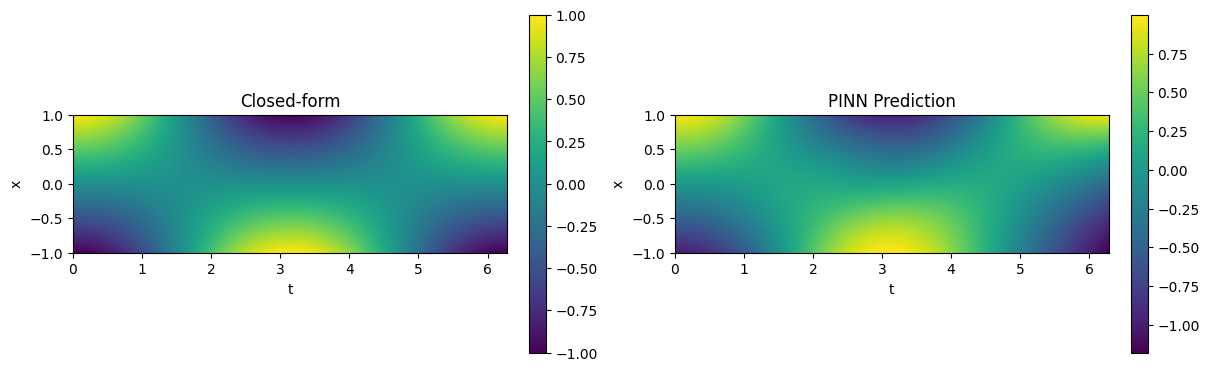

In [17]:
def load_checkpoint(path, device="cpu"):
    ck = torch.load(path, map_location=device)
    net = Sequentialmodel(np.array(ck["layers"]))
    net.load_state_dict(ck["model_state"])
    net.to(device).eval()
    return net, ck

model_best, ck = load_checkpoint("kg_forward_best.pt", device="cpu")

with torch.no_grad():
    x_test = torch.linspace(-1,1,600).view(-1,1)
    t_test = torch.rand(600,1) * T
    u_true = u_closed_form(x_test, t_test)
    u_pred = model_best(x_test, t_test)
    mse = torch.mean((u_pred - u_true)**2).item()
print(f"[BEST CKPT] MSE vs closed-form: {mse:.3e}")


compare(model_best)

MSE vs closed-form (grid): 1.052e-02


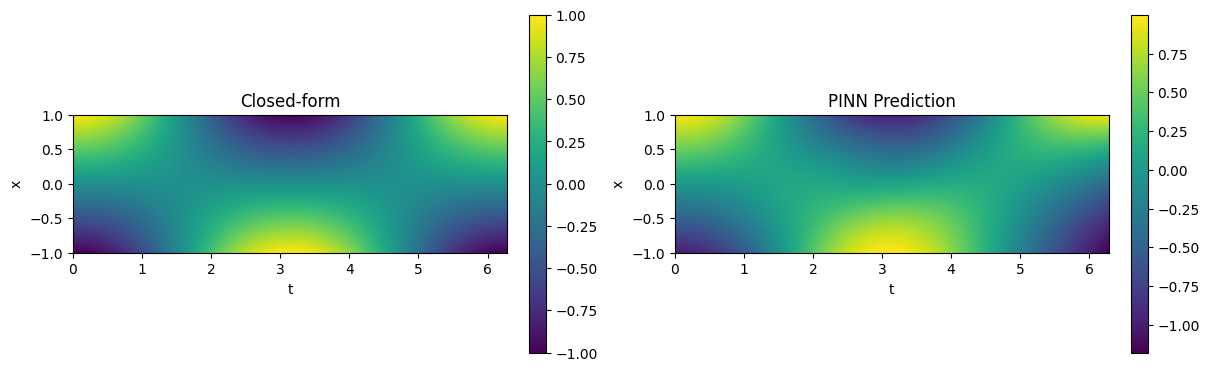

In [18]:
compare(PINN)

In [19]:
import os

def load_ckpt(path, device="cpu"):
    ck = torch.load(path, map_location=device)
    return ck

def plot_convergence(paths, labels=None, ylim=None):
    """
    paths: list[str] of .pt checkpoint files (each must contain 'outer_hist')
    labels: list[str] (optional), same length as paths
    """
    if labels is None: labels = [os.path.basename(p) for p in paths]
    plt.figure(figsize=(6.0, 4.0))
    for p, lab in zip(paths, labels):
        ck = load_ckpt(p)
        hist = ck["outer_hist"]
        plt.plot(hist, label=lab, linewidth=1.8)
    plt.xlabel("LBFGS outer step")
    plt.ylabel("Loss")
    if ylim: plt.ylim(*ylim)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title("Convergence")
    plt.tight_layout()
    plt.show()

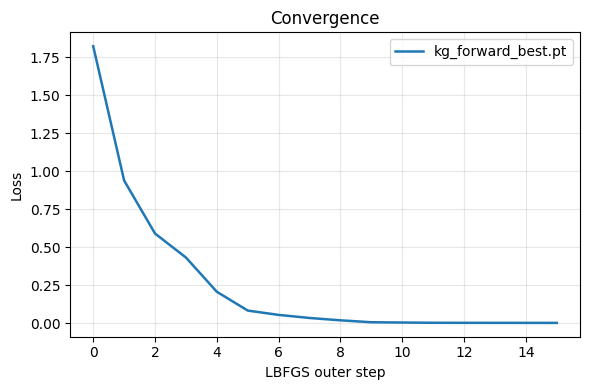

In [20]:
plot_convergence(["kg_forward_best.pt"])